In [1]:
import pandas as pd
from emle_bespoke.utils import create_dimer_topology
from openff.interchange import Interchange as _Interchange
from openff.toolkit import ForceField as _ForceField
import numpy as np
import openmm as mm
from emle.models import EMLE
from emle_bespoke._constants import HARTREE_TO_KJ_MOL
import torch
from emle_bespoke.lj_fitting import LennardJonesPotential as _LennardJonesPotential
import matplotlib.pyplot as plt
import seaborn as sns
from emle_bespoke.bespoke import BespokeModelTrainer as _BespokeModelTrainer
from collections import defaultdict
import numpy as np
import pickle


/home/joaomorado/opt/micromamba/envs/emle-bespoke/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indi

In [2]:
force_field = _ForceField("openff-2.0.0.offxml")

In [3]:
read = False
if read:
    with open("DESS66x8.pkl", "rb") as f:
        results = pickle.load(f)
    with open("dataset-66x8.pkl", "rb") as f:
        dataset = pickle.load(f)

    # Convert results dictionary to individual lists if necessary
    e_int_list = results["e_int_list"]
    xyz_mm_list = results["xyz_mm_list"]
    xyz_qm_list = results["xyz_qm_list"]
    xyz_list = results["xyz_list"]
    atomic_numbers_list = results["atomic_numbers_list"]
    charges_mm_list = results["charges_mm_list"]
    solute_mask_list = results["solute_mask_list"]
    solvent_mask_list = results["solvent_mask_list"]
else:
    df = pd.read_csv('/home/joaomorado/repos/emle-bespoke/utils/DESS66x8.csv')
    # Pre-allocate lists for results
    results = defaultdict(list)

    # Initialize force field and interchange object
    force_field = _ForceField("openff-2.0.0.offxml")

    # Get unique system IDs
    unique_ids = df["system_id"].unique()
    allowed_elements = ["H", "C", "N", "O", "S"]

    dataset = {}

    # Loop over unique IDs
    frame = 0
    for system_id in unique_ids:
        # Filter DataFrame for the current system ID
        df_filtered = df[df["system_id"] == system_id]
        smiles0, smiles1 = df_filtered.iloc[0][["smiles0", "smiles1"]]
        natoms0, natoms1 = df_filtered.iloc[0][["natoms0", "natoms1"]]
        charge0, charge1 = df_filtered.iloc[0][["charge0", "charge1"]]  
        elements = df_filtered.iloc[0]["elements"]

        if smiles0 != "O" and smiles1 != "O":
            continue

        if not all(elem in allowed_elements for elem in set(elements.split())):
            print(f"Skipping system {system_id} due to unsupported elements: {set(elements.split())}")
            continue
        if charge0 != 0 or charge1 != 0:
            print(f"Skipping system {system_id} due to non-zero charges: {charge0}, {charge1}")
            continue

        print(f"Processing system {system_id} out of {len(unique_ids)}")

        for i in range(1):
            #if smiles0 == "O":
            #    i = 1
            #else:
            #    i = 0
            # 
            if smiles0 == "O":
                i = 1
            else:
                i = 0 

            if i == 0:
                solute, solvent = smiles0, smiles1
                solute_idx = list(range(natoms0))
                solvent_idx = list(range(natoms0, natoms0 + natoms1))
            else:
                solute, solvent = smiles1, smiles0
                solute_idx = list(range(natoms0, natoms0 + natoms1))
                solvent_idx = list(range(natoms0))

            # Debugging print statement (optional)
            print(f"Processing system: {system_id}, Solute: {solute}, Solvent: {solvent}")
            # Create topology and extract molecules
            try:
                topology = create_dimer_topology(solute, solvent)
            except Exception as e:
                print(f"Skipping system {system_id} due to topology creation error: {e}")
                continue
            mols = list(topology.molecules)

            # Precompute atomic numbers and masks
            solute_atomic_numbers = [atom.atomic_number for atom in mols[0].atoms]
            solvent_atomic_numbers = [atom.atomic_number for atom in mols[1].atoms]
            atomic_numbers = np.array(solute_atomic_numbers + solvent_atomic_numbers, dtype=int)

            # Create solute and solvent masks
            solute_mask = np.arange(len(atomic_numbers)) < len(solute_atomic_numbers)
            solvent_mask = ~solute_mask

            # Create interchange and extract charges
            try:
                interchange = _Interchange.from_smirnoff(force_field=force_field, topology=topology)
            except Exception as e:
                print(f"Skipping system {system_id} due to Interchange creation error: {e}")
                continue
            system = interchange.to_openmm()
            nonbonded_force = next(
                f for f in system.getForces() if isinstance(f, mm.NonbondedForce)
            )
            charges = np.array([
                nonbonded_force.getParticleParameters(i)[0].value_in_unit(
                    nonbonded_force.getParticleParameters(i)[0].unit
                )
                for i in range(system.getNumParticles())
            ])
            charges_mm = charges[solvent_mask]

            # Process each row in the filtered DataFrame
            for _, row in df_filtered.iterrows():
                # Parse XYZ coordinates
                xyz = np.fromstring(row["xyz"], sep=" ").reshape(-1, 3)
                energy = row["cbs_CCSD(T)_all"] * 4.184
                
                # Append computed results to respective lists
                results["e_int_list"].append(energy)
                results["xyz_mm_list"].append(xyz[solvent_idx])
                results["xyz_qm_list"].append(xyz[solute_idx])
                results["xyz_list"].append(np.concatenate([xyz[solute_idx], xyz[solvent_idx]]))
                results["atomic_numbers_list"].append(np.asarray(solute_atomic_numbers))
                results["charges_mm_list"].append(charges_mm)
                results["solute_mask_list"].append(solute_mask)
                results["solvent_mask_list"].append(solvent_mask)
                results["topology_list"].append(topology)

                if system_id not in dataset:
                    dataset[system_id] = {"frames": [], "name": []}

                dataset[system_id]["frames"].append(frame)
                dataset[system_id]["name"].append(smiles0)
                dataset[system_id]["name"].append(smiles1)
                frame +=1

    # Save to pickle file
    with open("DESS66x8.pkl", "wb") as f:
        pickle.dump(results, f)

    with open("dataset-66x8.pkl", "wb") as f:
        pickle.dump(dataset, f)

# Convert results dictionary to individual lists if necessary
e_int_list = results["e_int_list"]
xyz_mm_list = results["xyz_mm_list"]
xyz_qm_list = results["xyz_qm_list"]
xyz_list = results["xyz_list"]
atomic_numbers_list = results["atomic_numbers_list"]
charges_mm_list = results["charges_mm_list"]
solute_mask_list = results["solute_mask_list"]
solvent_mask_list = results["solvent_mask_list"]

Processing system 11056 out of 54
Processing system: 11056, Solute: O, Solvent: O
Processing system 15449 out of 54
Processing system: 15449, Solute: CO, Solvent: O
Processing system 15235 out of 54
Processing system: 15235, Solute: CN, Solvent: O
Processing system 15038 out of 54
Processing system: 15038, Solute: CNC(=O)C, Solvent: O
Processing system 12400 out of 54
Processing system: 12400, Solute: c1cccnc1, Solvent: O
Processing system 12399 out of 54
Processing system: 12399, Solute: c1ccccc1, Solvent: O
Processing system 12703 out of 54
Processing system: 12703, Solute: C#C, Solvent: O


In [4]:
emle_model = "/home/joaomorado/mnsol_sampling/run_fixed/ml_mm_mechanical_iter_1/training/ligand_bespoke.mat"
emle_model = None

In [5]:
# Create the Lennard-Jones potential
lj_potential = _LennardJonesPotential(
    topology_off=results["topology_list"],
    forcefield=force_field,
    parameters_to_fit={
        "n-tip3p-O": {"sigma": True, "epsilon": True},
        "n-tip3p-H": {"sigma": False, "epsilon": False},
        "n16": {"sigma": True, "epsilon": True},
        "n19": {"sigma": True, "epsilon": True},
        "n3": {"sigma": True, "epsilon": True},
        "n12": {"sigma": True, "epsilon": True},
        "n20": {"sigma": True, "epsilon": True},
        "n11": {"sigma": True, "epsilon": True},
        "n14": {"sigma": True, "epsilon": True},
        "n17": {"sigma": True, "epsilon": True},
        "n2": {"sigma": True, "epsilon": True},
        "n7": {"sigma": True, "epsilon": True},
        "n8": {"sigma": True, "epsilon": True},
        "n15": {"sigma": True, "epsilon": True},
        "n10": {"sigma": True, "epsilon": True},
    },
    device=torch.device("cuda"),
)


2024-12-07 16:00:27.493 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:_build_lj_param_lookup:186 - Processing topology 0 / 80.
2024-12-07 16:00:27.817 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:95 - 
2024-12-07 16:00:27.818 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:96 - Lennard-Jones Parameters
2024-12-07 16:00:27.819 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:97 - ----------------------------------------
2024-12-07 16:00:27.819 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:98 - Atom Type        |   σ (nm) |   ε (kJ/mol)
2024-12-07 16:00:27.820 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:99 - ----------------------------------------
2024-12-07 16:00:27.820 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:103 - n-tip3p-O        |   0.3151 |       0.6364
2024-12-07 16:00:27.820 | DEBUG    | emle_bespoke.lj_fitting._lj_potentia

In [6]:
from emle.train._utils import pad_to_max
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

solvent_mask = pad_to_max(solvent_mask_list).to(device=device)
solute_mask = pad_to_max(solute_mask_list).to(device=device)
xyz = pad_to_max(xyz_list).to(device=device, dtype=dtype) * 0.1
xyz_qm = pad_to_max(xyz_qm_list).to(device=device, dtype=dtype) * 0.1
xyz_mm = pad_to_max(xyz_mm_list).to(device=device, dtype=dtype) * 0.1
atomic_numbers = pad_to_max(atomic_numbers_list).to(device=device, dtype=torch.int64)
charges_mm = pad_to_max(charges_mm_list).to(device=device, dtype=dtype)
e_int = torch.tensor(e_int_list).to(device=device, dtype=dtype)

In [7]:
e_lj_initial = lj_potential(xyz, solute_mask, solvent_mask).detach().cpu().numpy()

emle = EMLE(
    device=device,
    dtype=dtype,
    model=emle_model,
)
# do these in batches
batch_size = 1024
n_batches = len(e_int) // batch_size
e_static_emle = []
e_ind_emle = []
for i in range(n_batches + 1):
    print(f"Processing batch {i + 1} out of {n_batches}")
    e_static, e_ind = emle(atomic_numbers[i * batch_size:(i + 1) * batch_size], charges_mm[i * batch_size:(i + 1) * batch_size], xyz_qm[i * batch_size:(i + 1) * batch_size] * 10.0, xyz_mm[i * batch_size:(i + 1) * batch_size] * 10.0)
    e_static_emle.append(e_static.detach().cpu())
    e_ind_emle.append(e_ind.detach().cpu())

e_static_emle = torch.cat(e_static_emle)
e_ind_emle = torch.cat(e_ind_emle)

e_int_predicted = e_static_emle + e_ind_emle
e_int_predicted = e_int_predicted *  HARTREE_TO_KJ_MOL
e_int_predicted = e_int_predicted.detach().cpu().numpy()


Processing batch 1 out of 0


In [8]:
# Fit the Lennard-Jones potential
emle_bespoke = _BespokeModelTrainer(device=device, dtype=dtype)

lj_potential._e_static_emle = e_static_emle *  HARTREE_TO_KJ_MOL
lj_potential._e_ind_emle = e_ind_emle *  HARTREE_TO_KJ_MOL

emle_bespoke.fit_lj(
    lj_potential=lj_potential,
    xyz_qm=xyz_qm,
    xyz_mm=xyz_mm,
    xyz=xyz,
    atomic_numbers=atomic_numbers,
    charges_mm=charges_mm,
    e_int_target=e_int,
    solute_mask=solute_mask,
    solvent_mask=solvent_mask,
    lr=0.00001,
    epochs=10000,
    model=emle_model
)

2024-12-07 16:00:28.304 | INFO     | emle_bespoke.bespoke:fit_lj:521 - 
2024-12-07 16:00:28.304 | INFO     | emle_bespoke.bespoke:fit_lj:521 - ╔════════════════════════════════════════════════════════════╗
2024-12-07 16:00:28.304 | INFO     | emle_bespoke.bespoke:fit_lj:521 - ║            Starting fitting of LJ parameters...            ║
2024-12-07 16:00:28.305 | INFO     | emle_bespoke.bespoke:fit_lj:521 - ╚════════════════════════════════════════════════════════════╝
2024-12-07 16:00:28.305 | INFO     | emle_bespoke.bespoke:fit_lj:521 - 
/home/joaomorado/repos/emle-bespoke/src/emle_bespoke/bespoke.py:534: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  atomic_numbers = _torch.tensor(atomic_numbers)
/home/joaomorado/repos/emle-bespoke/src/emle_bespoke/bespoke.py:535: UserWarning: To copy construct from a tensor, it is recommended to use 

In [9]:
lj_potential.print_lj_parameters(lj_potential._lj_params)
e_lj_final = lj_potential(xyz, solute_mask, solvent_mask).detach().cpu().numpy()

2024-12-07 16:00:52.609 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:95 - 
2024-12-07 16:00:52.610 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:96 - Lennard-Jones Parameters
2024-12-07 16:00:52.610 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:97 - ----------------------------------------
2024-12-07 16:00:52.611 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:98 - Atom Type        |   σ (nm) |   ε (kJ/mol)
2024-12-07 16:00:52.611 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:99 - ----------------------------------------
2024-12-07 16:00:52.611 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:103 - n-tip3p-O        |   0.3009 |       0.6756
2024-12-07 16:00:52.611 | DEBUG    | emle_bespoke.lj_fitting._lj_potential:print_lj_parameters:103 - n-tip3p-H        |   0.1000 |       0.0000
2024-12-07 16:00:52.612 | DEBUG    | emle_bespoke.lj_fitting.

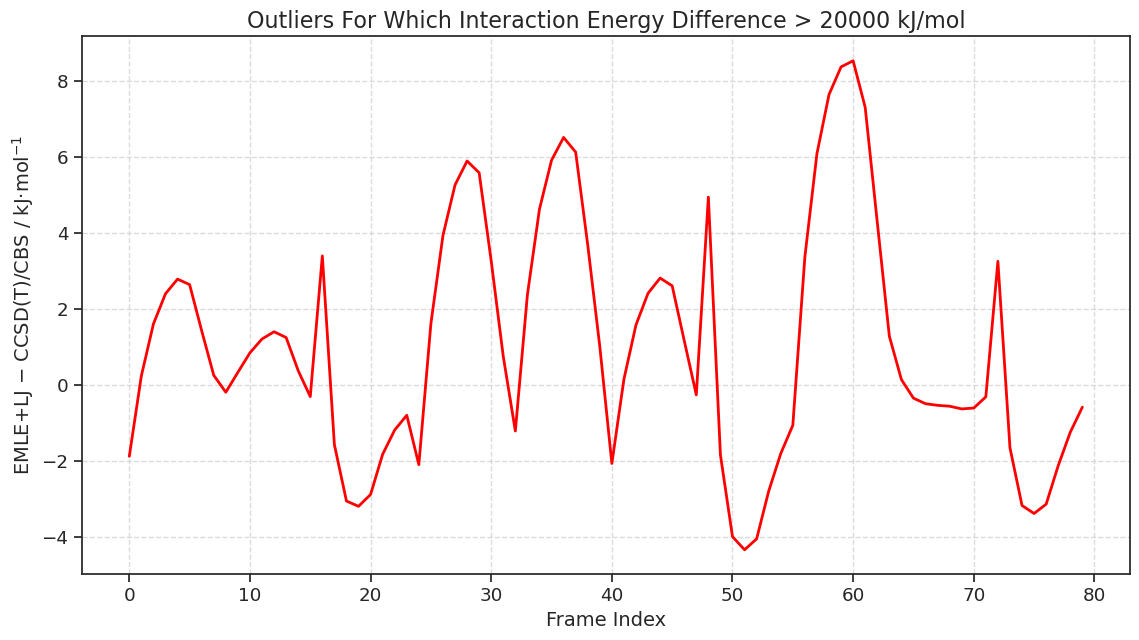

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Identify outliers
diff = e_int_predicted + e_lj_final - e_int_list
x = np.arange(0, len(e_lj_final))
outliers = x[diff > 500]
out_list = []

offset = 0
seen = []
for out in outliers:
    for k, v in dataset.items():
        if out > v["frames"][0] and out < v["frames"][-1]:
            if v["name"][0] + "_" + v["name"][1] in seen:
                continue
            else:
                seen.append(v["name"][0] + "_" + v["name"][1])
                offset += 200
            print(k, v["name"][0] + "_" + v["name"][1], out)
            out_list.append([out, 400 + offset, v["name"][0] + "_" + v["name"][1]])

# Set the Seaborn style for a clean look
sns.set(style="ticks", palette="muted", font_scale=1.2)

# Create a figure and axis
plt.figure(figsize=(12, 7))

# Plot the energy values as a line plot
#plt.plot(e_int_predicted + e_lj_initial, label='Initial', color='green', linewidth=2)
plt.plot(diff, label='Target', color='red', linewidth=2)

# Highlight the outliers with scatter points
outlier_x = [o[0] for o in out_list]
outlier_y = [o[1] for o in out_list]
plt.scatter(outlier_x, outlier_y, color='blue', marker='o', s=0.1, label='Outliers', zorder=5)

# Add labels and title
plt.xlabel('Frame Index', fontsize=14)
plt.ylabel('EMLE+LJ − CCSD(T)/CBS / kJ·mol$^{-1}$', fontsize=14)
plt.title('Outliers For Which Interaction Energy Difference > 20000 kJ/mol', fontsize=16)

# Add text annotations with a bounding box for visibility
for out in out_list:
    plt.text(out[0], out[1], f'{out[2]:s}', fontsize=10, color='black', 
             ha='center', va='bottom', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend to the plot
#plt.legend(loc='best', fontsize=12)

# Show the plot with adjusted layout
plt.tight_layout(pad=2.0)
plt.show()


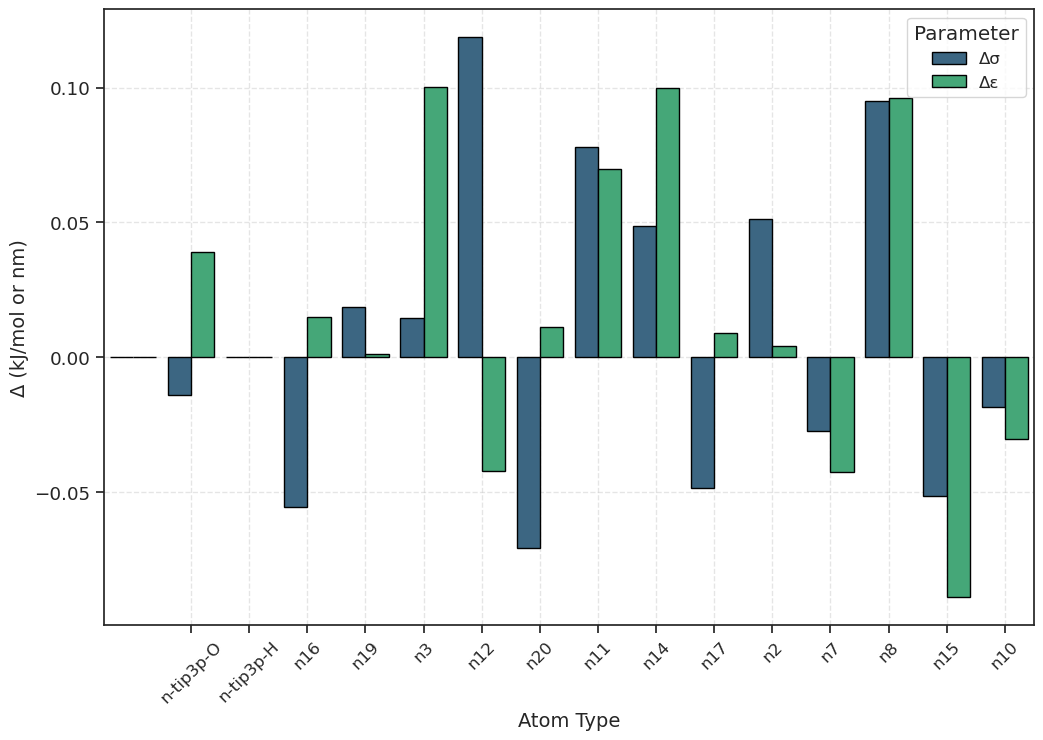

In [11]:

sigma_init = lj_potential._sigma_init.detach().cpu().numpy().squeeze()
sigma_final = lj_potential._sigma.detach().cpu().numpy().squeeze()
epsilon_init = lj_potential._epsilon_init.detach().cpu().numpy().squeeze() 
epsilon_final = lj_potential._epsilon.detach().cpu().numpy().squeeze()

# Example data (replace with your data)
atom_indices = np.arange(len(sigma_init))
delta_sigma = sigma_final - sigma_init  # Change in sigma
delta_epsilon = epsilon_final - epsilon_init  # Change in epsilon

# Create a DataFrame for Seaborn
data = pd.DataFrame({
    'Atom Index': np.tile(atom_indices, 2),
    'Δ': np.concatenate([delta_sigma, delta_epsilon]),
    'Parameter': ['Δσ'] * len(atom_indices) + ['Δε'] * len(atom_indices)
})

plt.figure(figsize=(12, 8))
sns.barplot(data=data, x='Atom Index', y='Δ', hue='Parameter', palette="viridis", edgecolor='black')
plt.xlabel("Atom Type", fontsize=14)
plt.ylabel("Δ (kJ/mol or nm)", fontsize=14)
atom_type_to_index = lj_potential._atom_type_to_index
index_to_atom_type = {v: k for k, v in atom_type_to_index.items()}
atom_types = [index_to_atom_type[i+1] for i in range(len(index_to_atom_type))]
plt.xticks(ticks=np.arange(len(atom_types))+1, labels=atom_types, fontsize=12, rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Parameter", fontsize=12)
plt.show()

In [12]:
e_lj_final = lj_potential(xyz, solute_mask, solvent_mask).detach().cpu().numpy()

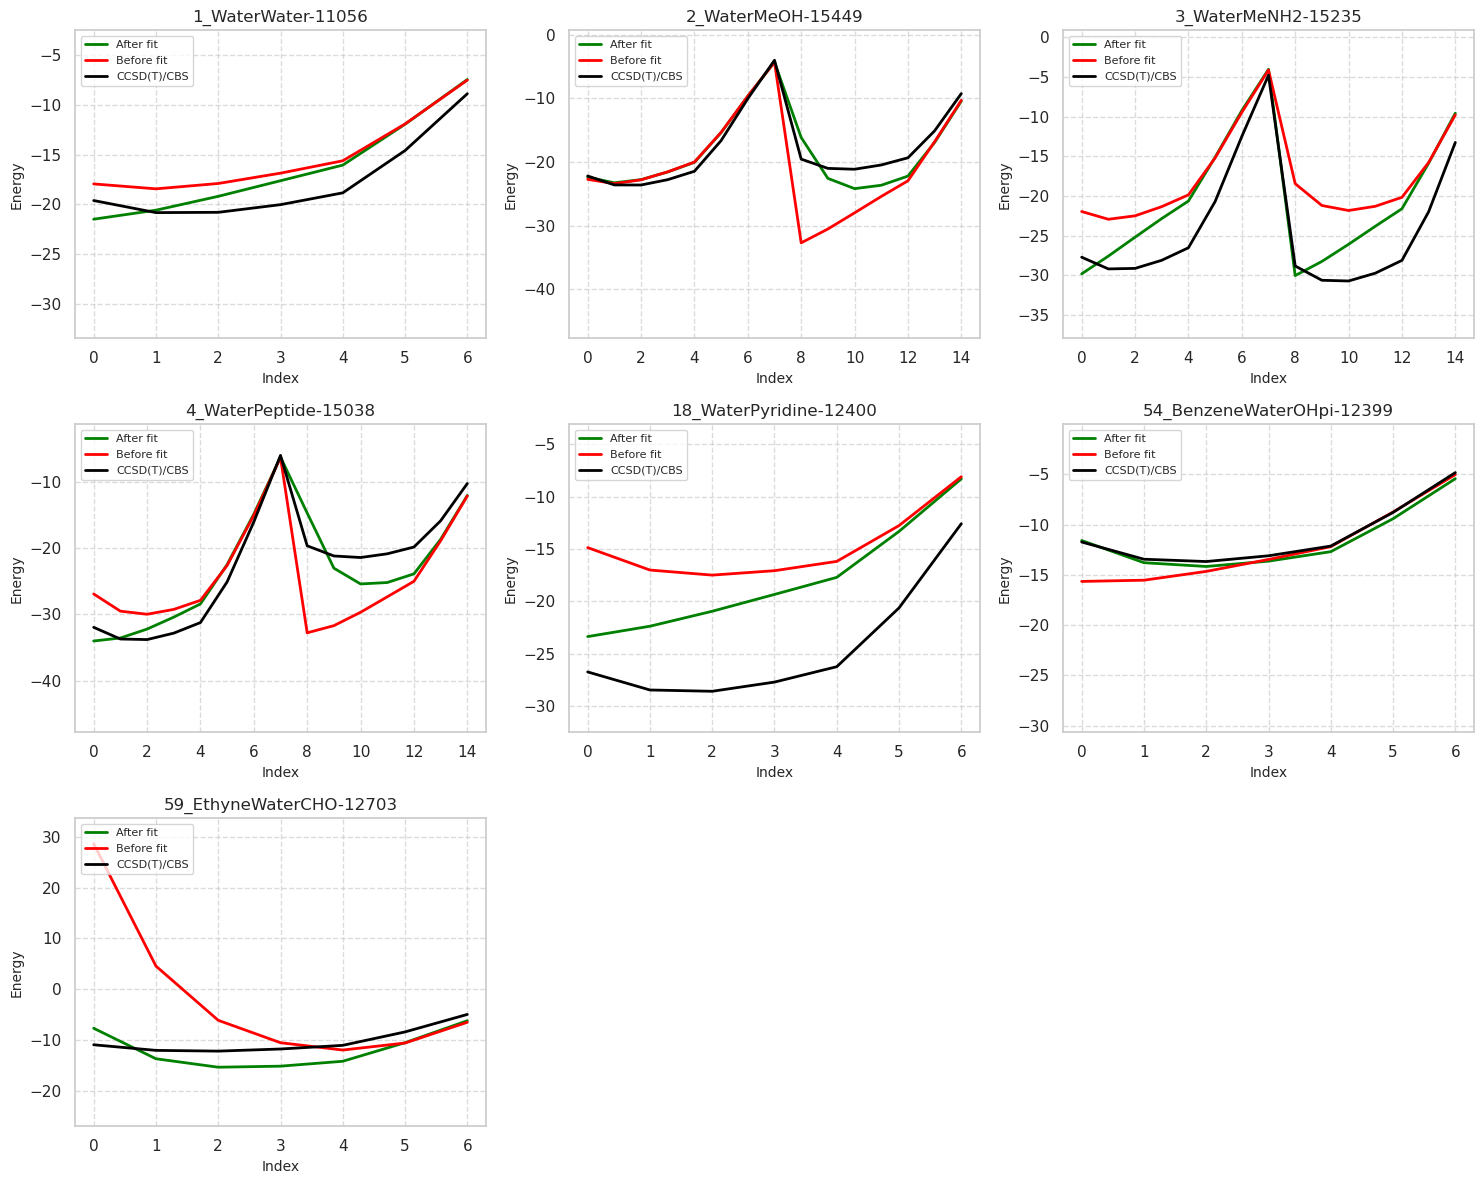

In [13]:
subset = dataset
num_systems = len(subset)
cols =  3# Number of columns
rows = int(np.ceil(num_systems / cols)) 

# Set the Seaborn style for a clean look
sns.set(style="whitegrid", palette="muted")

# Create a figure and axes for the 3xN grid
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=False, sharey=False)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through systems in the dataset
for i, (system_id, values) in enumerate(subset.items()):
    # Get the corresponding axis
    ax = axes[i]

    # Define x limits based on frame IDs
    x_min = values["frames"][0]
    x_max = values["frames"][-1]

    # Define y limits based on e_int_list values for these frames
    y_min = min(e_int_predicted[x_min:x_max] + e_lj_initial[x_min:x_max]) - 15
    y_max = max(e_int_predicted[x_min:x_max] + e_lj_initial[x_min:x_max]) + 5

    # Plot the energy values as a line plot
    ax.plot(e_int_predicted[x_min:x_max] + e_lj_final[x_min:x_max], label='After fit', color='green', linewidth=2)
    ax.plot(e_int_predicted[x_min:x_max] + e_lj_initial[x_min:x_max], label='Before fit', color='red', linewidth=2)
    ax.plot(e_int_list[x_min:x_max], label='CCSD(T)/CBS', color='black', linewidth=2)

    # Add labels and title
    ax.set_xlabel('Index', fontsize=10)
    ax.set_ylabel('Energy', fontsize=10)
    title = df[df["system_id"] == system_id]["system_name"].values[0]
    ax.set_title(f'{title}-{system_id}', fontsize=12)

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    #ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Add a legend to the plot
    ax.legend(fontsize=8, loc='upper left')

# Hide unused subplots if any
for j in range(num_systems, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()

# Show the grid of plots
plt.show()

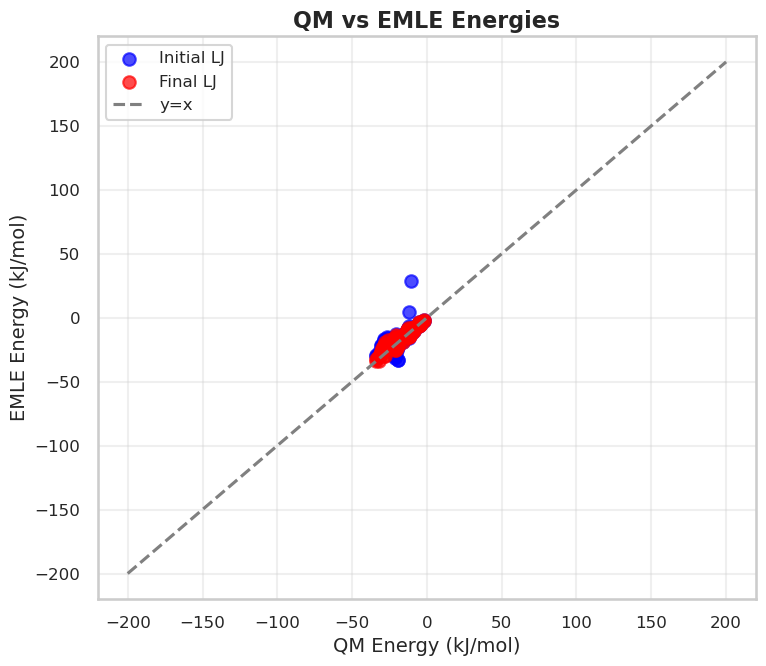

In [14]:
# Set Seaborn style for better aesthetics
sns.set(style="whitegrid", context="talk")

# Create the plot
plt.figure(figsize=(8, 7))
plt.scatter(e_int_list, e_int_predicted + e_lj_initial, color='blue', alpha=0.7, label='Initial LJ')
plt.scatter(e_int_list, e_int_predicted + e_lj_final, color='red', alpha=0.7, label='Final LJ')

# Add identity line for reference
min_energy = min(e_int_list)
max_energy = max(e_int_list)
plt.plot([-200,200], [-200, 200], color='gray', linestyle='--', label='y=x')

# Labels and title
plt.xlabel("QM Energy (kJ/mol)", fontsize=14)
plt.ylabel("EMLE Energy (kJ/mol)", fontsize=14)
plt.title("QM vs EMLE Energies", fontsize=16, weight='bold')

# Legend and grid
plt.legend(fontsize=12, loc='best')
plt.grid(alpha=0.3)

# Adjust ticks for readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Show plot
plt.tight_layout()
plt.show()
